# Geoparsing Workbook

## Named Entity Recognition

In [2]:
import pandas as pd
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_lg
nlp = en_core_web_lg.load()

/config/miniconda3/envs/ds/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'en_core_web_lg'

### Geoparser requires ElastiSearch container running

In [ ]:
from mordecai import Geoparser
geo = Geoparser()

In [ ]:
#this takes like 8 hours to run
def geoparsehelper(tweet):    
    try:
        result = geo.geoparse(tweet)
    except:
        result = []
    return result

data["place"] = data.apply(lambda x: geoparsehelper(x["tweet_text_processed"]),axis=1)
# drop columns that only have NaNs
data = data.dropna(axis=1, how='all')


### Save output of geoparse operation

In [ ]:
data.to_csv("redforedwithlocation.csv",dtype)

### Load output 

In [6]:
import pandas as pd
data = pd.read_csv('redforedwithlocation.csv')

/config/miniconda3/envs/ds/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Convert PLACE to LAT and LON

In [7]:
def filterhelp(x):
    try: 
        return len(x) > 2
    except: 
        return False


filterdf = data[data['place'].apply(lambda x: filterhelp(x))]

def lathelper(geo):
    try:
        return float(geo[geo.find('lat')+7:geo.find(',',geo.find('lat'))-1])
    except:
        pass
        
def lonhelper(geo):
    try:
        return float(geo[geo.find('lon')+7:geo.find(',',geo.find('lon'))-1])
    except:
        pass

filterdf["lat"] = filterdf["place"].apply(lambda x: lathelper(x))
filterdf["lon"] = filterdf["place"].apply(lambda x: lonhelper(x))
filterdf = filterdf[filterdf["lat"].notnull()]
#filterdf removes all tweets that don't have a location reference according to the geoparsing process

/tmp/ipykernel_76979/1014294894.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterdf["lat"] = filterdf["place"].apply(lambda x: lathelper(x))
/tmp/ipykernel_76979/1014294894.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterdf["lon"] = filterdf["place"].apply(lambda x: lonhelper(x))


## Static map

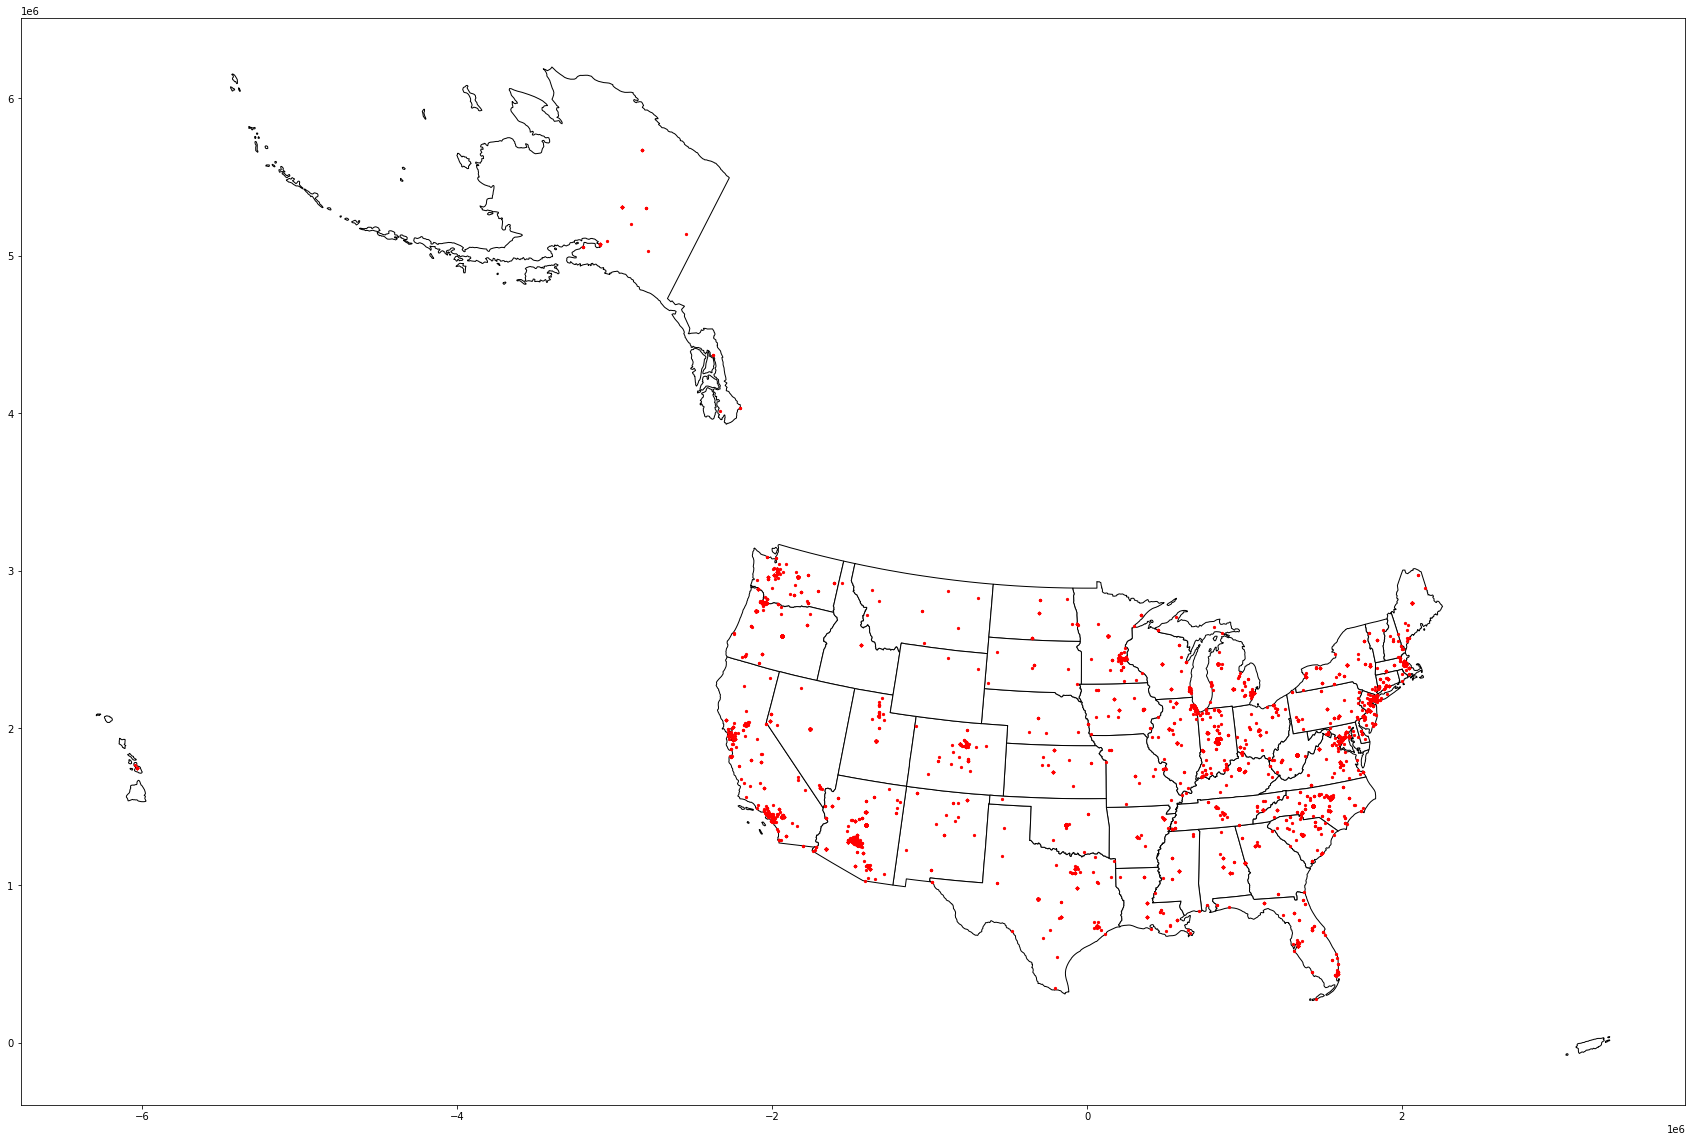

In [10]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import geopandas
import datetime

geodf = geopandas.GeoDataFrame(filterdf,crs="EPSG:4326",geometry=geopandas.points_from_xy(filterdf['lon'], filterdf['lat']))
geodf = geodf.to_crs("EPSG:5070")
# 5070 for Albers US focus
# 3395 for Mercator Global focus
#globe = geopandas.read_file('shapefiles/world_countries_2020.shp')
states = geopandas.read_file('shapefiles/cb_2018_us_state_20m.shp')
states = states.to_crs("EPSG:5070")
geodf = geopandas.clip(geodf,states)

fig, ax = plt.subplots(figsize=(50,20))
states.plot(ax=ax, color='white', edgecolor='black')
geodf.plot(ax=ax, marker='o', color='red', markersize=5)
plt.show();

## Animated GIF of map

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import geopandas
import datetime

geodf = geopandas.GeoDataFrame(filterdf,crs="EPSG:4326",geometry=geopandas.points_from_xy(filterdf['lon'], filterdf['lat']))
geodf = geodf.to_crs("EPSG:5070")
geodf.date = pd.to_datetime(geodf.date, format='%m/%d/%y')

states = geopandas.read_file('shapefiles/cb_2018_us_state_20m.shp')
states = states.to_crs("EPSG:5070")
states = states[(states["NAME"] != "Alaska") & (states["NAME"] != "Puerto Rico") & (states["NAME"] != "Hawaii")]
geodf = geopandas.clip(geodf,states)

fig, ax = plt.subplots(figsize=(50,20))


renderdate = pd.to_datetime('02/01/18',format='%m/%d/%y')
startdate = pd.to_datetime('02/01/18',format='%m/%d/%y')

# initialization function 
def init(): 
    states.plot(ax=ax, color='white', edgecolor='black')
    
# animation function 
def animate(i): 
    global renderdate
    renderdate = renderdate + datetime.timedelta(days=7)
    mask = (geodf['date'] > startdate) & (geodf['date'] <= renderdate)
    rendergeodf = geodf.loc[mask]
    rendergeodf.plot(ax=ax, marker='o', color='red', markersize=5)
    plt.title(renderdate)

anim = animation.FuncAnimation(fig, animate, init_func=init, interval=250, frames=120) 
anim.save('strikes.gif', writer='ffmpeg')
plt.show();

## Bokeh map

In [11]:
from bokeh.io import output_file, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, ColorBar
from bokeh.palettes import Viridis256
from bokeh.tile_providers import get_provider, Vendors
from pyproj import Transformer
from bokeh.plotting import figure, output_file, save

# Example dataframe with latitude and longitude coordinates
# Convert lat/lon to Web Mercator projection
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")
x, y = transformer.transform(filterdf['lat'].tolist(), filterdf['lon'].tolist())

# Create ColumnDataSource
df = pd.DataFrame()
df['label'] = filterdf['tweet_text_processed'].astype(str)
source = ColumnDataSource(data = dict(x=x, y=y, label=df['label'].tolist()))
map_provider = get_provider(Vendors.CARTODBPOSITRON)

# Set up Bokeh plot
p = figure(
    x_range = (-13884029,-7453304),
    y_range = (2698291,6455972),
    x_axis_type="mercator",
    y_axis_type="mercator",
    sizing_mode='stretch_both',
    background_fill_color='whitesmoke',
    border_fill_color='whitesmoke'
)
p.add_tile(map_provider)

# Remove axis and tickers
p.xaxis.visible = False
p.yaxis.visible = False
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

# Add circles to plot

p.circle(x='x', y='y', size=5, fill_color='red', fill_alpha=0.1, line_color="black", source=source,legend_label='Tweets')
hover = HoverTool(tooltips=[('Tweet', '@label')])
p.add_tools(hover)
# Add legend
p.legend.location = 'top_right'

# Save plot as HTML file
output_file('index.html')
save(p)

'/config/workspace/Dissertation/Dissertation/Data/index.html'